# Regressiemodellen

In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pyodbc
import matplotlib.pyplot as plt
import numpy as np

# Database connectie
De data komt uit de datawarehouse.

In [17]:
# database name
DB = {
    'servername': '(local)\\SQLEXPRESS',
    'database': 'DEDS_DataWarehouse'}

In [18]:
export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')


# Create a cursor from the connection
export_cursor = export_conn.cursor()

# check if connection is successful, else throw an error
if export_conn:
    print("Connection with database is established")
else:
    print("Connection with database is not established")
    raise Exception("Connection with database is not established")

Connection with database is established


# Tabellen inlezen
We hebben de order_header, order_details en order tabellen nodig

In [19]:
order_query = "SELECT * FROM [Order] WHERE CURRENT_VALUE = 1"

order_result = export_cursor.execute(order_query)
order_fetch = order_result.fetchall()
order_columns = [column[0] for column in order_result.description]
order = pd.DataFrame.from_records(order_fetch, columns=order_columns)

# dropping current value and last updated columns
order = order.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

order

,ORDER_SK,ORDER_order_number,ORDER_ORDER_METHOD_CODE_method_code,ORDER_ORDER_METHOD_EN_method
0,1,1153,7,Sales visit
1,2,1154,4,E-mail
2,3,1155,7,Sales visit
3,4,1156,5,Web
4,5,1157,2,Telephone
...,...,...,...,...
5355,5356,9475,4,E-mail
5356,5357,9476,5,Web
5357,5358,9477,2,Telephone
5358,5359,9478,7,Sales visit


In [20]:
order_header_query = "SELECT * FROM Order_header WHERE CURRENT_VALUE = 1"

order_header_result = export_cursor.execute(order_header_query)
order_header_fetch = order_header_result.fetchall()
order_header_columns = [column[0] for column in order_header_result.description]
order_header = pd.DataFrame.from_records(order_header_fetch, columns=order_header_columns)

# dropping current value and last updated columns
order_header = order_header.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

order_header

,ORDER_HEADER_SK,ORDER_HEADER_number,ORDER_HEADER_RETAILER_CODE,ORDER_HEADER_SALES_STAFF_CODE,ORDER_HEADER_SALES_BRANCH_CODE,ORDER_HEADER_ORDER_DATE,ORDER_HEADER_RETAILER_SITE_CODE,ORDER_HEADER_RETAILER_CONTACT_CODE,ORDER_HEADER_ORDER_order_number
0,1,1153,100,54,5,2020-04-14,285,349,1
1,2,1154,100,54,5,2020-10-01,285,349,2
2,3,1155,100,52,5,2020-04-21,340,355,3
3,4,1156,100,52,5,2020-09-09,340,355,4
4,5,1157,100,54,5,2020-04-10,351,356,5
...,...,...,...,...,...,...,...,...,...
4960,4961,9430,89,41,3,2022-09-15,225,222,5311
4961,4962,9431,89,41,3,2022-12-02,225,222,5312
4962,4963,9447,89,43,3,2020-10-08,225,222,5328
4963,4964,9448,89,41,3,2021-10-14,225,222,5329


In [21]:
order_details_query = "SELECT * FROM Order_details WHERE CURRENT_VALUE = 1"

order_details_result = export_cursor.execute(order_details_query)
order_details_fetch = order_details_result.fetchall()
order_details_columns = [column[0] for column in order_details_result.description]
order_details = pd.DataFrame.from_records(order_details_fetch, columns=order_details_columns)

# dropping current value and last updated columns
order_details = order_details.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

order_details

,ORDER_DETAILS_SK,ORDER_DETAILS_code,ORDER_DETAILS_QUANTITY_quantity,ORDER_DETAILS_TOTAL_COST_total,ORDER_DETAILS_TOTAL_MARGIN_margin,ORDER_DETAILS_ORDER_NUMBER_order,ORDER_DETAILS_PRODUCT_NUMBER_product,ORDER_DETAILS_UNIT_ID_unit
0,1,100000,16,257.6000,360.6400,4405,112,1
1,2,100001,20,322.0000,450.8000,5008,112,2
2,3,100002,24,386.4000,540.9600,4394,112,3
3,4,100003,18,289.8000,405.7200,4396,112,4
4,5,100004,20,322.0000,450.8000,4382,112,5
...,...,...,...,...,...,...,...,...
43058,43059,99995,146,402.9600,810.3000,4402,111,43059
43059,43060,99996,172,474.7200,954.6000,4400,111,43060
43060,43061,99997,192,529.9200,1065.6000,5148,111,43061
43061,43062,99998,192,529.9200,1065.6000,4384,111,43062


In [22]:
unit_query = "SELECT * FROM Unit WHERE CURRENT_VALUE = 1"

unit_result = export_cursor.execute(unit_query)
unit_fetch = unit_result.fetchall()
unit_columns = [column[0] for column in unit_result.description]
unit = pd.DataFrame.from_records(unit_fetch, columns=unit_columns)

# dropping current value and last updated columns
unit = unit.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

unit

,UNIT_SK,UNIT_id,UNIT_COST_cost,UNIT_PRICE_price,UNIT_SALE_sale
0,1,1,16.1000,22.5400,22.5400
1,2,2,16.1000,22.5400,22.5400
2,3,3,16.1000,22.5400,22.5400
3,4,4,16.1000,22.5400,22.5400
4,5,5,16.1000,22.5400,22.5400
...,...,...,...,...,...
43058,43059,43059,2.7600,5.5500,5.5500
43059,43060,43060,2.7600,5.5500,5.5500
43060,43061,43061,2.7600,5.5500,5.5500
43061,43062,43062,2.7600,5.5500,5.5500


In [23]:
product_query = "SELECT * FROM Product WHERE CURRENT_VALUE = 1"

product_result = export_cursor.execute(product_query)
product_fetch = product_result.fetchall()
product_columns = [column[0] for column in product_result.description]
product = pd.DataFrame.from_records(product_fetch, columns=product_columns)

# dropping current value and last updated columns
product = product.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED'])

product

,PRODUCT_SK,PRODUCT_number,PRODUCT_name_product,PRODUCT_description_description,PRODUCT_image_image,PRODUCT_INTRODUCTION_DATE_introduced,PRODUCT_PRODUCTION_COST_cost,PRODUCT_MARGIN_margin,PRODUCT_LANGUAGE_language,PRODUCT_MINIMUM_SALE_PRICE_minPrice,PRODUCT_PRODUCT_LINE_code,PRODUCT_PRODUCT_LINE_code_en,PRODUCT_PRODUCT_TYPE_code,PRODUCT_PRODUCT_TYPE_code_en
0,1,1,TrailChef Water Bag,"Lightweight, collapsible bag to carry liquids ...",P01CE1CG1.jpg,2011-02-15,4.0000,0.3300,EN,4.3300,1,Camping Equipment,1,Cooking Gear
1,2,10,TrailChef Utensils,"Spoon, fork and knife set made of a light yet ...",P10CE1CG1.jpg,2011-02-15,10.0000,0.4000,EN,10.4000,1,Camping Equipment,1,Cooking Gear
2,3,100,Insect Bite Relief,The Insect Bite Relief helps the itching and s...,P100OP4FA17.jpg,2011-02-15,3.0000,0.5000,EN,3.5000,4,Outdoor Protection,17,First Aid
3,4,101,Hailstorm Steel Irons,Iron is 17-4 stainless steel. Shafts are grap...,P101GE5IR18.jpg,2019-12-15,305.5400,0.4300,EN,305.9700,5,Golf Equipment,18,Irons
4,5,102,Hailstorm Titanium Irons,Made entirely of pure titanium. The ultimate i...,P102GE5IR18.jpg,2019-10-12,380.9500,0.5100,EN,381.4600,5,Golf Equipment,18,Irons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,111,95,Sun Shield,"PABA free sunscreen, SPF 30, poison oak and iv...",P91OP4SS16.jpg,2011-02-15,3.0000,0.5000,EN,3.5000,4,Outdoor Protection,16,Sunscreen
111,112,96,Compact Relief Kit,A personal first aid kit is recommended for ev...,P96OP4FA17.jpg,2011-02-15,16.4300,0.2800,EN,16.7100,4,Outdoor Protection,17,First Aid
112,113,97,Deluxe Family Relief Kit,A complete medical kit suitable for families w...,P96OP4FA17.jpg,2013-05-03,25.0000,0.2800,EN,25.2800,4,Outdoor Protection,17,First Aid
113,114,98,Calamine Relief,Use the Calamine Relief for allergic skin reac...,P98OP4FA17.jpg,2011-02-15,3.0000,0.5000,EN,3.5000,4,Outdoor Protection,17,First Aid


# Database connectie sluiten

In [ ]:
export_cursor.close()
export_conn.close()

## De tabellen samenvoegen tot 1 dataframe

In [24]:
order_combined = pd.merge(order_header, order, left_on='ORDER_HEADER_ORDER_order_number', right_on='ORDER_SK')
order_combined = pd.merge(order_combined, order_details, left_on='ORDER_SK', right_on='ORDER_DETAILS_ORDER_NUMBER_order')
order_combined = pd.merge(order_combined, unit, left_on='ORDER_DETAILS_UNIT_ID_unit', right_on='UNIT_SK')
order_combined = pd.merge(order_combined, product, left_on='ORDER_DETAILS_PRODUCT_NUMBER_product', right_on='PRODUCT_SK')

order_combined

,ORDER_HEADER_SK,ORDER_HEADER_number,ORDER_HEADER_RETAILER_CODE,ORDER_HEADER_SALES_STAFF_CODE,ORDER_HEADER_SALES_BRANCH_CODE,ORDER_HEADER_ORDER_DATE,ORDER_HEADER_RETAILER_SITE_CODE,ORDER_HEADER_RETAILER_CONTACT_CODE,ORDER_HEADER_ORDER_order_number,ORDER_SK,...,PRODUCT_image_image,PRODUCT_INTRODUCTION_DATE_introduced,PRODUCT_PRODUCTION_COST_cost,PRODUCT_MARGIN_margin,PRODUCT_LANGUAGE_language,PRODUCT_MINIMUM_SALE_PRICE_minPrice,PRODUCT_PRODUCT_LINE_code,PRODUCT_PRODUCT_LINE_code_en,PRODUCT_PRODUCT_TYPE_code,PRODUCT_PRODUCT_TYPE_code_en
0,1,1153,100,54,5,2020-04-14,285,349,1,1,...,P02CE1CG1.jpg,2011-02-15,9.2200,0.2300,EN,9.4500,1,Camping Equipment,1,Cooking Gear
1,1,1153,100,54,5,2020-04-14,285,349,1,1,...,P32CE1LT5.jpg,2011-02-15,16.6700,0.3300,EN,17.0000,1,Camping Equipment,5,Lanterns
2,1,1153,100,54,5,2020-04-14,285,349,1,1,...,P35CE1LT5.jpg,2016-10-26,17.7800,0.2500,EN,18.0300,1,Camping Equipment,5,Lanterns
3,1,1153,100,54,5,2020-04-14,285,349,1,1,...,P36CE1LT5.jpg,2011-02-15,18.0500,0.4000,EN,18.4500,1,Camping Equipment,5,Lanterns
4,1,1153,100,54,5,2020-04-14,285,349,1,1,...,P39CE1LT5.jpg,2013-05-03,40.6300,0.3700,EN,41.0000,1,Camping Equipment,5,Lanterns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37788,4965,9449,89,43,3,2022-10-06,225,222,5330,5330,...,P64PA3WT10.jpg,2011-02-15,20.0000,0.5000,EN,20.5000,3,Personal Accessories,10,Watches
37789,4965,9449,89,43,3,2022-10-06,225,222,5330,5330,...,P65PA3WT10.jpg,2013-05-03,39.0000,0.5000,EN,39.5000,3,Personal Accessories,10,Watches
37790,4965,9449,89,43,3,2022-10-06,225,222,5330,5330,...,P86OP4IR15.jpg,2011-02-15,2.0000,0.6700,EN,2.6700,4,Outdoor Protection,15,Insect Repellents
37791,4965,9449,89,43,3,2022-10-06,225,222,5330,5330,...,P109GE5PT20.jpg,2019-10-12,35.0000,0.4300,EN,35.4300,5,Golf Equipment,20,Putters


# Data voorbereiden
Om de verkopen te kunnen voorspellen, moeten we de data voorbereiden. We willen de verkopen voorspellen op basis van de orderdatum en een aantal orderdetails.

In [25]:
# removing the sk columns
sk_columns = order_combined.filter(like='SK').columns
order_combined.drop(columns=sk_columns, inplace=True)

# removing columns we won't need
remove_columns = ['ORDER_HEADER_number', 'ORDER_HEADER_RETAILER_CODE', 'ORDER_HEADER_SALES_STAFF_CODE', 'ORDER_HEADER_SALES_BRANCH_CODE', 'ORDER_HEADER_RETAILER_SITE_CODE', 'ORDER_HEADER_RETAILER_CONTACT_CODE', 'ORDER_HEADER_ORDER_order_number', 'ORDER_order_number', 'ORDER_ORDER_METHOD_EN_method', 'ORDER_DETAILS_code', 'ORDER_DETAILS_ORDER_NUMBER_order', 'ORDER_DETAILS_PRODUCT_NUMBER_product', 'ORDER_DETAILS_UNIT_ID_unit', 'UNIT_id', 'PRODUCT_image_image', 'PRODUCT_PRODUCT_LINE_code_en', 'PRODUCT_PRODUCT_TYPE_code_en', 'PRODUCT_name_product', 'PRODUCT_description_description', 'PRODUCT_LANGUAGE_language', 'ORDER_DETAILS_TOTAL_COST_total', 'ORDER_DETAILS_TOTAL_MARGIN_margin', 'PRODUCT_PRODUCTION_COST_cost', 'PRODUCT_MARGIN_margin', 'PRODUCT_MINIMUM_SALE_PRICE_minPrice', 'UNIT_COST_cost']

order_combined.drop(columns=remove_columns, inplace=True)

order_combined

,ORDER_HEADER_ORDER_DATE,ORDER_ORDER_METHOD_CODE_method_code,ORDER_DETAILS_QUANTITY_quantity,UNIT_PRICE_price,UNIT_SALE_sale,PRODUCT_number,PRODUCT_INTRODUCTION_DATE_introduced,PRODUCT_PRODUCT_LINE_code,PRODUCT_PRODUCT_TYPE_code
0,2020-04-14,7,100,12.5300,11.8100,2,2011-02-15,1,1
1,2020-04-14,7,254,27.3700,25.1000,32,2011-02-15,1,5
2,2020-04-14,7,114,26.5400,24.8200,35,2016-10-26,1,5
3,2020-04-14,7,130,34.9000,31.4400,36,2011-02-15,1,5
4,2020-04-14,7,74,67.7300,61.3800,39,2013-05-03,1,5
...,...,...,...,...,...,...,...,...,...
37788,2022-10-06,2,120,40.0000,40.0000,64,2011-02-15,3,10
37789,2022-10-06,2,146,78.0000,75.6900,65,2013-05-03,3,10
37790,2022-10-06,2,66,6.0000,6.0000,87,2011-02-15,4,15
37791,2022-10-06,2,70,63.0000,63.0000,109,2019-10-12,5,20


In [26]:
# converting the columns to the right data types
order_combined['ORDER_HEADER_ORDER_DATE'] = pd.to_datetime(order_combined['ORDER_HEADER_ORDER_DATE'], format='%Y-%m-%d')
order_combined['ORDER_ORDER_METHOD_CODE_method_code'] = order_combined['ORDER_DETAILS_QUANTITY_quantity'].astype(int)
order_combined['ORDER_DETAILS_QUANTITY_quantity'] = order_combined['ORDER_DETAILS_QUANTITY_quantity'].astype(int)
order_combined['UNIT_PRICE_price'] = order_combined['UNIT_PRICE_price'].astype(float)
order_combined['UNIT_SALE_sale'] = order_combined['UNIT_SALE_sale'].astype(float)
order_combined[ 'PRODUCT_number'] = order_combined[ 'PRODUCT_number'].astype(int)
order_combined['PRODUCT_INTRODUCTION_DATE_introduced'] = pd.to_datetime(order_combined['PRODUCT_INTRODUCTION_DATE_introduced'], format='%Y-%m-%d')
order_combined['PRODUCT_PRODUCT_LINE_code'] = order_combined['PRODUCT_PRODUCT_LINE_code'].astype(int)
order_combined['PRODUCT_PRODUCT_TYPE_code'] = order_combined['PRODUCT_PRODUCT_TYPE_code'].astype(int)

# Convert datetime objects to numeric representation
order_combined['ORDER_HEADER_ORDER_DATE'] = order_combined['ORDER_HEADER_ORDER_DATE'].apply(lambda x: x.toordinal())
order_combined['PRODUCT_INTRODUCTION_DATE_introduced'] = order_combined['PRODUCT_INTRODUCTION_DATE_introduced'].apply(lambda x: x.toordinal())

# Voorspellen
We willen de ORDER_DETAILS_QUANTITY_quantity voorspellen op basis van de andere kolommen.

In [27]:
# split the data
x = order_combined.drop(columns=['ORDER_DETAILS_QUANTITY_quantity'])
y = order_combined['ORDER_DETAILS_QUANTITY_quantity']

# split the data into training and testing data. Randomly so it changes every time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(x.columns)

Index(['ORDER_HEADER_ORDER_DATE', 'ORDER_ORDER_METHOD_CODE_method_code',
       'UNIT_PRICE_price', 'UNIT_SALE_sale', 'PRODUCT_number',
       'PRODUCT_INTRODUCTION_DATE_introduced', 'PRODUCT_PRODUCT_LINE_code',
       'PRODUCT_PRODUCT_TYPE_code'],
      dtype='object')


## Regressie model trainen

In [28]:
# create the model
model = LinearRegression()
model.fit(x_train, y_train)

# predict the test data
y_pred = model.predict(x_test)

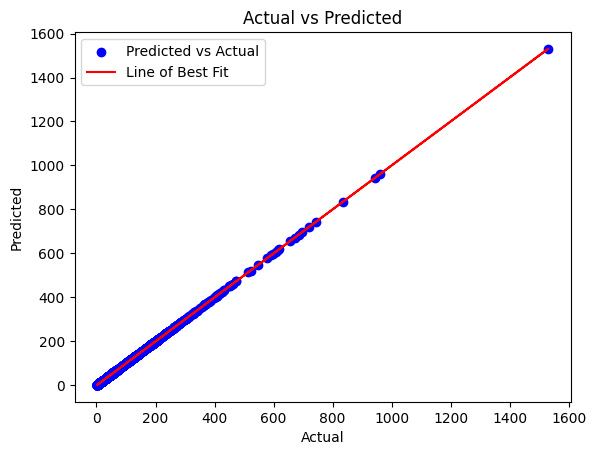

In [29]:
# Scatter plot of actual test data vs predicted values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')

# Line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red', label='Line of Best Fit')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()

# Show the plot
plt.show()

In [30]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
sse = mse * len(y_test)
mae = np.mean(np.abs(y_test - y_pred))

# way to low, idk how to fix this
print('Mean Squared Error:', mse)
print('Sum of Squared Error:', sse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 9.579795735362859e-26
Sum of Squared Error: 7.241367596360785e-22
Mean Absolute Error: 2.514159449928234e-13
